# Week 4: Retrieval-Augmented Generation (RAG) – Python Class
## Learning Objectives
* Understand the RAG architecture and its components

* Implement text embedding and similarity search

* Process text through tokenization, filtering, and chunking

* Store and retrieve data using a vector database

* Integrate RAG with LLMs using LangChain

* Evaluate RAG system performance using appropriate metrics

## Setup Instructions
Ensure you have the following packages installed:

In [ ]:
! pip install --upgrade langchain langchain-core langchain-community langchain-openai langchain-experimental chromadb

setting your OpenAI API key as an environment variable in .env file

In [ ]:
# in your .env file, change your-openai-api-key to actual openai api key
OPENAI_API_KEY='your-openai-api-key'

# Full code

In [3]:
import os
from langchain_core.documents import Document
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from IPython.display import display, HTML

class RAGClass:
    def __init__(self, data_path: str):
        """
        Initialize the RAGClass with the path to the data file.
        """
        self.data_path = data_path
        self.documents = []
        self.text_chunks = []
        self.vectorstore = None
        self.retriever = None
        self.qa_chain = None

    def load_documents(self):
        """
        Loads documents from the specified data path and stores them in self.documents.
        Returns the loaded documents.
        """
        loader = TextLoader(self.data_path)
        self.documents = loader.load()
        # print(f"Loaded {len(self.documents)} documents.")
        for i, doc in enumerate(self.documents):
            preview = doc.page_content[:200].replace('\n', '<br>')
            display(HTML(f"<b>Document {i+1} content preview:</b><br>{preview}{'...' if len(doc.page_content) > 200 else ''}<hr>"))
        return self.documents

    def split_documents(self, chunk_size=500, chunk_overlap=50):
        """
        Splits loaded documents into smaller chunks for processing.
        Returns the list of text chunks.
        """
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
        self.text_chunks = text_splitter.split_documents(self.documents)
        print(f"Split documents into {len(self.text_chunks)} chunks.")
        for i, chunk in enumerate(self.text_chunks):
            formatted_text = chunk.page_content.replace('. ', '.<br>')
            display(HTML(f"<b>Chunk {i+1}:</b><br>{formatted_text}<hr>"))
        return self.text_chunks

    def create_vectorstore(self):
        """
        Creates a vector store from the split text chunks using OpenAI embeddings.
        Returns the vectorstore object.
        """
        if not self.text_chunks:
            raise ValueError("No text chunks found. Please split documents before creating the vector store.")
        embeddings = OpenAIEmbeddings()
        self.vectorstore = Chroma.from_documents(self.text_chunks, embedding=embeddings)
        print("Vectorstore created with embedded documents.")
        display(HTML("<b>Vectorstore Contents:</b>"))
        for i, doc in enumerate(self.text_chunks):
            formatted_text = doc.page_content.replace('. ', '.<br>')
            display(HTML(f"<b>Document {i+1}:</b><br>{formatted_text}<hr>"))
        return self.vectorstore

    def setup_retriever(self):
        """
        Sets up a retriever from the vectorstore for similarity search.
        Returns the retriever object.
        """
        if self.vectorstore is None:
            raise ValueError("Vectorstore not initialized.")
        self.retriever = self.vectorstore.as_retriever()
        print("Retriever set up from vectorstore.")
        display(HTML(f"<b>Retriever details:</b> {self.retriever}"))
        return self.retriever

    def setup_qa_chain(self):
        """
        Initializes the QA chain using a language model and the retriever.
        Returns the QA chain object.
        """
        if self.retriever is None:
            raise ValueError("Retriever not initialized.")
        llm = ChatOpenAI(model_name="gpt-4", temperature=0)
        self.qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=self.retriever)
        print("QA chain initialized with LLM and retriever.")
        display(HTML(f"<b>QA chain details:</b> {self.qa_chain}"))
        return self.qa_chain

    def answer_query(self, query: str):
        """
        Answers a query using the QA chain.
        Returns the answer string.
        """
        if self.qa_chain is None:
            raise ValueError("QA chain not initialized.")
        result = self.qa_chain.run(query)
        display(HTML(f"<b>Query:</b> {query}<br><b>Answer:</b> {result}"))
        return result

    def evaluate(self, queries: list, ground_truths: list):
        """
        Evaluates the QA system using a list of queries and ground truths.
        Returns the accuracy as a float.
        """
        if len(queries) != len(ground_truths):
            raise ValueError("Queries and ground truths must be of the same length.")
        if self.qa_chain is None:
            raise ValueError("QA chain not initialized.")
        correct = 0
        for idx, (query, truth) in enumerate(zip(queries, ground_truths)):
            answer = self.qa_chain.run(query)
            display(HTML(f"<b>Query {idx+1}:</b> {query}<br><b>Expected:</b> {truth}<br><b>Model Answer:</b> {answer}<hr>"))
            if truth.lower() in answer.lower():
                correct += 1
        accuracy = correct / len(queries)
        display(HTML(f"<b>Evaluation Accuracy:</b> {accuracy * 100:.2f}%"))
        return accuracy

## Step-by-Step Breakdown of the RAG Pipeline
### 1. Load Environment Variables

In [9]:
from dotenv import load_dotenv
import os

load_dotenv()  # Loads variables from a .env file into the environment
api_key = os.getenv("OPENAI_API_KEY")

LangChain is a powerful framework that facilitates the development of applications powered by large language models (LLMs).  <br/>
When integrating OpenAI's models (like GPT-3.5 or GPT-4) into your LangChain application, authentication is essential.  <br/>
This is achieved through the OPENAI_API_KEY, which grants authorized access to OpenAI's API endpoints. <br/>

Steps:

1. Create a `.env` File:
In the root directory of your project, create a file named `.env`.

2. Add Your API Key:
Inside the `.env`file, add the following line:
`OPENAI_API_KEY`=`your_openai_api_key_here`

This code snippet reads the .env file and sets the `OPENAI_API_KEY` in your environment, making it accessible to your application.

### How LangChain Utilizes the API Key
Once the `OPENAI_API_KEY` is set in your environment, LangChain's OpenAI integrations can seamlessly access it.
 For instance, when you initialize a language model in LangChain:

        
```python
                        from langchain_openai import OpenAI
                        llm = OpenAI()
```
LangChain internally retrieves the API key from the environment variable and uses it to authenticate requests to OpenAI's API. <br/>
This design abstracts away the need to manually pass the API key each time, promoting cleaner and more secure code.

### 2. Initialize the RAG Class with Data Path

In [4]:
rag = RAGClass(data_path="my_text_file.txt")
print(rag)


Explanation:
Here, you instantiate the RAGClass, providing the path to your text data. This class will manage the RAG pipeline processes.

Expected Outcome:
An instance of RAGClass is created, ready to process the specified text file.

### 3. Load and Process Documents

In [72]:
rag.load_documents()

[Document(metadata={'source': 'my_text_file.txt'}, page_content='Retrieval-Augmented Generation (RAG) is a technique that combines information retrieval with text generation. It enhances the capabilities of language models by providing them with access to external knowledge sources.\n\nText embeddings are numerical representations of text that capture semantic meaning. They are used to measure similarity between pieces of text.\n\nVector databases store these embeddings and allow for efficient similarity searches.\n\nLangChain is a framework that facilitates the development of applications powered by language models. It provides tools for integrating LLMs with external data sources.\n\nEvaluation metrics for RAG systems include precision, recall, and F1 score, which assess the quality of the generated responses.\n')]

Explanation:
This method uses LangChain's TextLoader to read the contents of the specified text file and load them into the pipeline.

Expected Outcome:
The text file is read, and its contents are stored as a document within the RAGClass instance.

### 4. Split Documents into Chunks

```python

    def split_documents(self, chunk_size=500, chunk_overlap=50):
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
        self.text_chunks = text_splitter.split_documents(self.documents)
        print(f"Split documents into {len(self.text_chunks)} chunks.")
        
        # Print each chunk with line breaks after periods
        for i, chunk in enumerate(self.text_chunks):
            print(f"\nChunk {i+1}:")
            formatted_text = chunk.page_content.replace(". ", ".\n")
            print(formatted_text)

```

<details>
  <summary>Code explaination</summary>
  <text>
* Understanding RecursiveCharacterTextSplitter
    The RecursiveCharacterTextSplitter is a utility in LangChain designed to divide large text documents into smaller, manageable chunks. </br>
    This is particularly useful when working with language models that have input size limitations.

* Key Parameters:

    * chunk_size: Defines the maximum number of characters in each chunk.
    * chunk_overlap: Specifies the number of characters that should overlap between consecutive chunks. This overlap ensures context is preserved across chunks.

* How It Works
The splitter operates by attempting to divide the text using a hierarchy of separators, aiming to preserve the semantic integrity of the content. The default separator hierarchy is:

    1. Paragraph breaks (\n\n)
    2. Line breaks (\n)
    3. DataStax Documentation
    4. Spaces ( )
    5. No separator (character-level split)

    The splitter recursively applies these separators to break the text into chunks that do not exceed the specified chunk_size. </br>
    If a chunk is still too large after applying all separators, it will be split at the character level.
  </text>
</details>

In [73]:
rag.split_documents()

Split documents into 2 chunks.


[Document(metadata={'source': 'my_text_file.txt'}, page_content='Retrieval-Augmented Generation (RAG) is a technique that combines information retrieval with text generation. It enhances the capabilities of language models by providing them with access to external knowledge sources.\n\nText embeddings are numerical representations of text that capture semantic meaning. They are used to measure similarity between pieces of text.\n\nVector databases store these embeddings and allow for efficient similarity searches.'),
 Document(metadata={'source': 'my_text_file.txt'}, page_content='LangChain is a framework that facilitates the development of applications powered by language models. It provides tools for integrating LLMs with external data sources.\n\nEvaluation metrics for RAG systems include precision, recall, and F1 score, which assess the quality of the generated responses.')]

## 5. Create Vector Store

```python
    def create_vectorstore(self):
        embeddings = OpenAIEmbeddings()
        self.vectorstore = Chroma.from_documents(self.text_chunks, embedding=embeddings)
```

<details>
  <summary>Code explaination</summary>
  <text>
* This function performs two primary tasks:

Initialize the Embedding Model: It creates an instance of OpenAIEmbeddings, which is responsible for generating vector representations (embeddings) of text using OpenAI's embedding models.

Create the Vector Store: It constructs a Chroma vector store from the previously split text chunks, utilizing the embeddings generated in the first step.

1. Initializing OpenAIEmbeddings
        `embeddings = OpenAIEmbeddings()`
* Purpose: This line initializes the embedding model that will convert text into numerical vector representations. </br>
By default, it uses OpenAI's text-embedding-ada-002 model, but you can specify other models if needed.

* Interaction with OpenAI API:
    * When you later use this embeddings instance to embed text (as in the next step), it sends requests to OpenAI's API, utilizing your provided API key for authentication.

    * Each text chunk is sent to the API, and the corresponding embedding vector is returned. 

2. Creating the Chroma Vector Store
    `self.vectorstore = Chroma.from_documents(self.text_chunks, embedding=embeddings)`

* Purpose: This line creates a Chroma vector store by embedding each text chunk and storing the resulting vectors. Chroma is an open-source vector database optimized for handling embeddings and facilitating similarity searches.

* Process:

    * Embedding Text Chunks: Each document in `self.text_chunks` is passed through the embeddings instance to obtain its vector representation.

    * Storing Embeddings: The resulting vectors are stored in the Chroma vector store, allowing for efficient similarity searches later on.

* Interaction with OpenAI API:

    * For each document, a request is sent to OpenAI's embedding endpoint to obtain its vector representation.

    * These embeddings are then stored in Chroma, not in OpenAI's systems.
  </text>
</details>

</br>

<details>
  <summary>Integration in a RAG Pipeline</summary>
  <text>

In a Retrieval-Augmented Generation (RAG) pipeline, this function is crucial for setting up the vector store that enables efficient retrieval of relevant information:

1. Document Processing: Raw documents are loaded and split into manageable chunks.

2. Embedding Generation: Each chunk is converted into a vector using OpenAI's embedding models.

3. Vector Store Creation: The embeddings are stored in Chroma, facilitating quick similarity searches.

4. Query Handling: When a user query is received, it's embedded and compared against the stored vectors to retrieve the most relevant chunks.

5. Answer Generation: The retrieved chunks provide context to a language model (like OpenAI's GPT-4) to generate a comprehensive answer.
  </text>
</details>

In [75]:
rag.create_vectorstore()

Vectorstore created with embedded documents.


Explanation:
Each text chunk is converted into a vector embedding using OpenAI's embedding model. These embeddings are stored in a vector database (e.g., Chroma) for similarity searches.

Expected Outcome:
A vector store is created, containing embeddings of all text chunks, enabling efficient similarity-based retrieval.

## 6. Set Up Retriever
```python 
    def setup_retriever(self):
        """
        Sets up a retriever from the vectorstore for similarity search.
        Returns the retriever object.
        """
        if self.vectorstore is None:
            raise ValueError("Vectorstore not initialized.")
        self.retriever = self.vectorstore.as_retriever()
        print("Retriever set up from vectorstore.")
        display(HTML(f"<b>Retriever details:</b> {self.retriever}"))
        return self.retriever
```


<details>
  <summary>Code explaination</summary>
  <text>
This method performs the following steps:

1. Validation: Checks if the vectorstore has been initialized. If not, it raises an error.

2. Retriever Initialization: Converts the existing vector store into a retriever using the `as_retriever()` method.

3. Feedback: Prints a confirmation message and displays the retriever's details.

4. Return: Returns the retriever object for further use.
  </text>
</details>
</br>

<details>
  <summary>Understanding the Components</summary>
  <text>

#### 1. Vector Store
 * A vector store is a specialized database designed to store vector embeddings of documents. </br>
In this context, the vector store (e.g., Chroma) holds the embeddings generated from your text documents.</br> 
These embeddings allow for efficient similarity searches based on vector distances.

#### 2. Retriever
* A retriever is an abstraction that facilitates the retrieval of relevant documents from the vector store based on a query. </br>
By converting the vector store into a retriever, you enable the system to fetch documents that are semantically similar to a given input.

#### Integration in a RAG Pipeline
In a Retrieval-Augmented Generation pipeline, the retriever plays a crucial role:

1. Query Embedding: A user's query is converted into an embedding using the same embedding model used for the documents.

2. Similarity Search: The retriever searches the vector store for document embeddings that are closest to the query embedding.

3. Contextual Retrieval: The most relevant documents are retrieved and provided as context to the language model.
Niklas Heidloff

4. Answer Generation: The language model generates a response based on the retrieved context and the original query.

#### Customizing the Retriever
The as_retriever() method can accept parameters to customize its behavior:

* search_type: Defines the search strategy. Options include:

    * "similarity": Retrieves documents based on vector similarity.
    * "mmr" (Maximal Marginal Relevance): Balances relevance and diversity in the results.
    * "similarity_score_threshold": Retrieves documents with a similarity score above a certain threshold.
* search_kwargs: A dictionary of additional parameters, such as:
    * k: Number of documents to retrieve.
    * score_threshold: Minimum similarity score for a document to be considered relevant.

  </text>
</details>

In [76]:
rag.setup_retriever()

Retriever set up from vectorstore.


VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x133842920>, search_kwargs={})

Explanation:
A retriever is configured to search the vector store for chunks most relevant to a given query, based on vector similarity.

Expected Outcome:
The retriever is ready to fetch relevant document chunks in response to user queries.

## 7. Set Up QA Chain

```python
    def setup_qa_chain(self):
        """
        Initializes the QA chain using a language model and the retriever.
        Returns the QA chain object.
        """
        if self.retriever is None:
            raise ValueError("Retriever not initialized.")
        llm = ChatOpenAI(model_name="gpt-4", temperature=0)
        self.qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=self.retriever)
        print("QA chain initialized with LLM and retriever.")
        display(HTML(f"<b>QA chain details:</b> {self.qa_chain}"))
        return self.qa_chain
```


<details>
  <summary>Code explaination</summary>
  <text>
This method performs the following steps:

1. Validation: Checks if the `retriever` has been initialized. If not, it raises an error.

2. Language Model Initialization: Creates an instance of `ChatOpenAI` with the specified model and temperature settings.

3. QA Chain Creation: Uses `RetrievalQA.from_chain_type` to create a question-answering chain that integrates the language model and retriever.

4. Feedback: Prints a confirmation message and displays the QA chain's details.

5. Return: Returns the QA chain object for further use.
  </text>
</details>
</br>
<details>
  <summary>Understanding the Components</summary>
  <text>

#### 1. ChatOpenAI
* This is a wrapper around OpenAI's chat models (like GPT-4) provided by LangChain. </br>
It allows for easy integration of OpenAI's language models into LangChain workflows.

    * model_name="gpt-4": Specifies the use of OpenAI's GPT-4 model.
    * temperature=0: Sets the randomness of the model's output. A temperature of 0 makes the output more deterministic and focused.

#### 2. RetrievalQA.from_chain_type
This method creates a RetrievalQA chain by combining a language model (llm) and a retriever. </br>
* It simplifies the process of setting up a retrieval-augmented question-answering system.
    * llm=llm: Passes the initialized language model to the chain.
    * retriever=self.retriever: Passes the retriever, which is responsible for fetching relevant documents based on a query.

#### Integration in a RAG Pipeline
In a Retrieval-Augmented Generation pipeline, this QA chain plays a crucial role:
    1. User Query: A user inputs a question.
    2. Document Retrieval: The retriever searches the vector store for documents relevant to the query.
    3. Answer Generation: The language model processes the retrieved documents and the original query to generate a comprehensive answer.

#### Customization Options
The RetrievalQA.from_chain_type method allows for various customizations:
* chain_type: Specifies how to combine the documents. Options include:

    * "stuff": Concatenates all documents and passes them to the language model.

    * "map_reduce": Processes each document individually and then combines the results.

    * "refine": Generates an initial answer and refines it with each additional document.

* chain_type_kwargs: Allows for additional parameters, such as custom prompts.
  </text>
</details>

In [77]:
rag.setup_qa_chain()


QA chain initialized with LLM and retriever.


RetrievalQA(verbose=False, combine_documents_chain=StuffDocumentsChain(verbose=False, llm_chain=LLMChain(verbose=False, prompt=ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'], input_types={}, partial_variables={}, template="Use the following pieces of context to answer the user's question. \nIf you don't know the answer, just say that you don't know, don't try to make up an answer.\n----------------\n{context}"), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='{question}'), additional_kwargs={})]), llm=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x133843ee0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x13384caf0>, root_client=<openai.OpenAI object at 0x133854a90>,

Explanation:
A question-answering chain is established, combining the retriever and an OpenAI language model to generate answers based on retrieved document chunks.

Expected Outcome:
The QA chain is prepared to handle queries, retrieving relevant information and generating coherent responses.

## 8. Answer a Sample Query

In [78]:
rag.answer_query("What is Retrieval-Augmented Generation?")

'Retrieval-Augmented Generation (RAG) is a technique that combines information retrieval with text generation. It enhances the capabilities of language models by providing them with access to external knowledge sources.'

Explanation:
This method processes a user query through the QA chain, retrieving pertinent information and generating an answer.

Expected Outcome:
A comprehensive answer to the question "What is Retrieval-Augmented Generation?" is generated, based on the content of your text file.

# 9. Evaluate the System

In [79]:
sample_queries = ["Define RAG.", "Explain vector databases."]
sample_ground_truths = ["Retrieval-Augmented Generation", "Vector databases store embeddings"]
rag.evaluate(sample_queries, sample_ground_truths)

0.5

Explanation:
The system's performance is assessed by comparing its responses to known correct answers (ground truths) for a set of sample queries.

Expected Outcome:
Evaluation metrics (e.g., accuracy, precision) are computed, providing insights into the system's effectiveness.

## Full code 

In [56]:
import os
from langchain_core.documents import Document
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from IPython.display import display, HTML

class RAGClass:
    def __init__(self, data_path: str):
        """
        Initialize the RAGClass with the path to the data file.
        """
        self.data_path = data_path
        self.documents = []
        self.text_chunks = []
        self.vectorstore = None
        self.retriever = None
        self.qa_chain = None

    def load_documents(self):
        """
        Loads documents from the specified data path and stores them in self.documents.
        Returns the loaded documents.
        """
        loader = TextLoader(self.data_path)
        self.documents = loader.load()
        # print(f"Loaded {len(self.documents)} documents.")
        for i, doc in enumerate(self.documents):
            preview = doc.page_content[:200].replace('\n', '<br>')
            display(HTML(f"<b>Document {i+1} content preview:</b><br>{preview}{'...' if len(doc.page_content) > 200 else ''}<hr>"))
        return self.documents

    def split_documents(self, chunk_size=500, chunk_overlap=50):
        """
        Splits loaded documents into smaller chunks for processing.
        Returns the list of text chunks.
        """
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
        self.text_chunks = text_splitter.split_documents(self.documents)
        print(f"Split documents into {len(self.text_chunks)} chunks.")
        for i, chunk in enumerate(self.text_chunks):
            formatted_text = chunk.page_content.replace('. ', '.<br>')
            display(HTML(f"<b>Chunk {i+1}:</b><br>{formatted_text}<hr>"))
        return self.text_chunks

    def create_vectorstore(self):
        """
        Creates a vector store from the split text chunks using OpenAI embeddings.
        Returns the vectorstore object.
        """
        if not self.text_chunks:
            raise ValueError("No text chunks found. Please split documents before creating the vector store.")
        embeddings = OpenAIEmbeddings()
        self.vectorstore = Chroma.from_documents(self.text_chunks, embedding=embeddings)
        print("Vectorstore created with embedded documents.")
        display(HTML("<b>Vectorstore Contents:</b>"))
        for i, doc in enumerate(self.text_chunks):
            formatted_text = doc.page_content.replace('. ', '.<br>')
            display(HTML(f"<b>Document {i+1}:</b><br>{formatted_text}<hr>"))
        return self.vectorstore

    def setup_retriever(self):
        """
        Sets up a retriever from the vectorstore for similarity search.
        Returns the retriever object.
        """
        if self.vectorstore is None:
            raise ValueError("Vectorstore not initialized.")
        self.retriever = self.vectorstore.as_retriever()
        print("Retriever set up from vectorstore.")
        display(HTML(f"<b>Retriever details:</b> {self.retriever}"))
        return self.retriever

    def setup_qa_chain(self):
        """
        Initializes the QA chain using a language model and the retriever.
        Returns the QA chain object.
        """
        if self.retriever is None:
            raise ValueError("Retriever not initialized.")
        llm = ChatOpenAI(model_name="gpt-4", temperature=0)
        self.qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=self.retriever)
        print("QA chain initialized with LLM and retriever.")
        display(HTML(f"<b>QA chain details:</b> {self.qa_chain}"))
        return self.qa_chain

    def answer_query(self, query: str):
        """
        Answers a query using the QA chain.
        Returns the answer string.
        """
        if self.qa_chain is None:
            raise ValueError("QA chain not initialized.")
        result = self.qa_chain.run(query)
        display(HTML(f"<b>Query:</b> {query}<br><b>Answer:</b> {result}"))
        return result

    def evaluate(self, queries: list, ground_truths: list):
        """
        Evaluates the QA system using a list of queries and ground truths.
        Returns the accuracy as a float.
        """
        if len(queries) != len(ground_truths):
            raise ValueError("Queries and ground truths must be of the same length.")
        if self.qa_chain is None:
            raise ValueError("QA chain not initialized.")
        correct = 0
        for idx, (query, truth) in enumerate(zip(queries, ground_truths)):
            answer = self.qa_chain.run(query)
            display(HTML(f"<b>Query {idx+1}:</b> {query}<br><b>Expected:</b> {truth}<br><b>Model Answer:</b> {answer}<hr>"))
            if truth.lower() in answer.lower():
                correct += 1
        accuracy = correct / len(queries)
        display(HTML(f"<b>Evaluation Accuracy:</b> {accuracy * 100:.2f}%"))
        return accuracy

In [8]:
from dotenv import load_dotenv
import os

load_dotenv()  # This will load variables from the .env file into the environment

# Now you can access the API key
api_key = os.getenv("OPENAI_API_KEY")


# Initialize the RAG class with the path to your data
rag = RAGClass(data_path="my_text_file.txt")

# Load and process documents
rag.load_documents()
rag.split_documents()
rag.create_vectorstore()
rag.setup_retriever()
rag.setup_qa_chain()

# Answer a sample query
rag.answer_query("What is Retrieval-Augmented Generation?")

# Evaluate the system with sample queries and ground truths
sample_queries = ["Define RAG.", "Explain vector databases."]
sample_ground_truths = ["Retrieval-Augmented Generation", "Vector databases store embeddings"]
rag.evaluate(sample_queries, sample_ground_truths)


Loaded 1 documents.
Split documents into 2 chunks.
Vectorstore created with embedded documents.
Retriever set up from vectorstore.
QA chain initialized with LLM and retriever.


/var/folders/73/v36xqm_16qlckbh0hgrshdr40000gn/T/ipykernel_47190/338421976.py:49: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = self.qa_chain.run(query)


Query: What is Retrieval-Augmented Generation?
Answer: Retrieval-Augmented Generation (RAG) is a technique that combines information retrieval with text generation. It enhances the capabilities of language models by providing them with access to external knowledge sources. This allows the models to generate more informed and accurate responses.
Evaluation Accuracy: 50.00%


# Intro to Course Project: Your Own AI‑Powered Application
## Why this matters for your resume & LinkedIn
- Portfolio Showpiece: You’ll deliver a working AI system—exactly the kind of hands‑on project recruiters love to see.

- Real‑World Skillset: From data ingestion to RAG integration to deployment patterns, you'll demonstrate end‑to‑end mastery.

- Stand Out: A polished project (with code repo, demo video, and write‑up) is a conversation starter in interviews.



## Project Pitch & Brainstorming:

Think about problems you care about (e.g., domain‑specific Q&A, personal knowledge assistant, document explorer).

Sketch 2–3 ideas: scope, inputs (PDFs, web pages, databases), desired outputs.

## Inspiration + Learning Resources:

- Local RAG from Scratch (step‑by‑step):

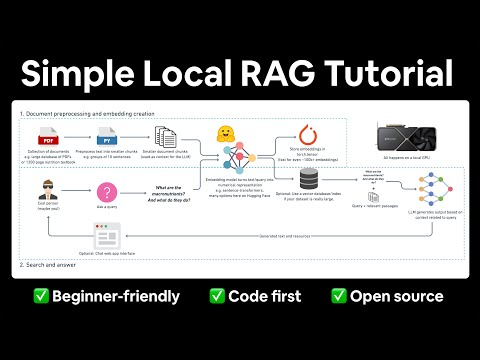

In [2]:
from IPython.display import YouTubeVideo

# Display the YouTube video directly in the notebook
YouTubeVideo('qN_2fnOPY-M', start=3)

- Comprehensive LangChain RAG Tutorial

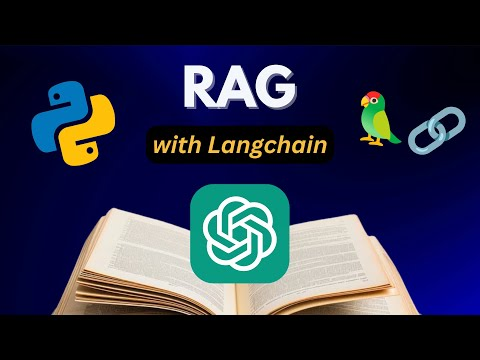

In [3]:
YouTubeVideo('YLPNA1j7kmQ', start=3)

# Class Project: “My Resume AI Assistant”

## Project Vision
- Ingest: Take your résumé (PDF or DOCX) plus any supporting portfolio documents.

- RAG Layer (Week 4): Build a vector index over those documents so the agent can retrieve exact snippets (experience bullet, project detail) to answer user questions like “What technologies did I use on Project X?”

- SFT Layer (Weeks 5–7+): Fine‑tune a small LLM on your own Q&A pairs or conversational logs so it internalizes style, tone, and deeper context—making it feel like you speaking, not just quoting text.



In [10]:
! pip install pypdf
# # for CUDA supported GPU
# ! pip install faiss-gpu 
# # for CPU
# ! pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 2.5 MB/s eta 0:00:00a 0:00:01


## Inference AI set up
### 1. GPU Set Up
sign in the console at: https://console.inference.ai/

1. `Create New Server` 
2. Default setting, `Configure`
3. Advanced Options -> Enabled the `SSH Access`
4. `Manage` SSH Access 
    - open your terminal type: ` cat ~/.ssh/id_rsa.pub `

    - If the .ssh directory doesn't exist or you don't find any public key files, you'll need to generate a new SSH key pair using the ssh-keygen command. check [this](https://docs.github.com/en/enterprise-cloud@latest/authentication/connecting-to-github-with-ssh/checking-for-existing-ssh-keys)
    
    - Copy the ssh public key and paste into inference AI ssh key management box.
    
    - `close`

5. `Deploy Server`

6. In the Running Instances, click `Show Details`

7. copy SSH Access such that `ssh jovyan@216.81.245.8 -p 30932`

8. `ssh -L 8000:localhost:8000 jovyan@216.81.245.8 -p 30932`

### 2. System Set Up (in the same remote console)

1. Download the Vllm using `pip install vllm` 
- [What is vllm ?](https://docs.vllm.ai/en/latest/)
    - vLLM is an open-source library designed for efficient and high-throughput serving of Large Language Models (LLMs). It focuses on optimizing memory management during inference, particularly with techniques like "PagedAttention," which reduces KV-cache waste. vLLM offers faster serving speeds, seamless integration with popular Hugging Face models, and supports various decoding algorithms like parallel sampling and beam search. 

2. Set up HuggingFace
- go to https://huggingface.co/settings/tokens to generate the new token
- `huggingface-cli login`

3. Download model from HuggingFace 
    ```
    python3 -m vllm.entrypoints.openai.api_server \
    --model HuggingFaceH4/zephyr-7b-alpha \
    --port 8000 \
    --gpu-memory-utilization 0.99 \
    --max-model-len 2048
    ```


In [ ]:
# Down load the embeading model
! pip install sentence-transformers
! pip install accelerate bitsandbytes

## API Version Embedding

In [14]:
from langchain.document_loaders import PyPDFLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
from dotenv import load_dotenv
import os


load_dotenv()  # This will load variables from the .env file into the environment

# Now you can access the API key
api_key = os.getenv("OPENAI_API_KEY")


# 1) LOAD your resume & docs
resume = PyPDFLoader("./python-developer-resume-example.pdf").load()
extras = TextLoader("./portfolio_notes.txt").load()
docs = resume + extras

# 2) CHUNK
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

# 3) EMBED + INDEX
emb = OpenAIEmbeddings(openai_api_key=api_key)
vectorstore = FAISS.from_documents(chunks, emb)

# 4) MAKE RAG chain
llm = OpenAI(temperature=0)
agent = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever(search_kwargs={"k":3})
)

def ask_me(question):
    print(agent.run(question))

# example
if __name__=="__main__":
    ask_me("What Python projects have Giulia contributed?")


 Giulia has contributed to open-source Python utilities and has also experimented with automation tools on her personal GitHub. She has also worked with Python in her previous roles at DoorDash and Knewton.


## GPU Version Embedding

In [26]:
import os
from dotenv import load_dotenv
from langchain.document_loaders import PyPDFLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI

# 1. Load your documents
resume = PyPDFLoader("./python-developer-resume-example.pdf").load()
extras = TextLoader("./portfolio_notes.txt").load()
docs = resume + extras

# 2. Split documents into chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

# 3. Create embeddings with OpenAI (you can replace this later with local embedding models)
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)
vectorstore = FAISS.from_documents(chunks, embedding_model)



# 4. Connect to your vLLM server running on port 8000 (via SSH tunnel or locally)
llm = ChatOpenAI(
    openai_api_base="http://localhost:8000/v1",
    openai_api_key="not-needed",
    model_name="HuggingFaceH4/zephyr-7b-alpha"  # matches your vLLM launch
)

# 5. Retrieval QA chain
agent = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever(search_kwargs={"k": 3})
)

# 6. Ask a question
def ask_me(question):
    print(agent.run(question))

if __name__ == "__main__":
    ask_me("What Python projects has Giulia contributed?")


/var/folders/73/v36xqm_16qlckbh0hgrshdr40000gn/T/ipykernel_33458/3211169354.py:20: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


The text provided does not offer specific information about any Python projects that Giulia has contributed to. However, it mentions that she maintains a personal GitHub where she contributes to open-source Python utilities and occasionally writes tutorials on using Django with cloud-native databases.


## Next Steps 
1. Choose your domain & data (e.g., legal briefs, academic papers, support tickets).

2. Watch those two tutorials to see RAG patterns in action.

3. Draft a short project proposal (1 paragraph):

    - Goal: What question will your agent answer?

    - Data: Where will you pull content from?

    - Output: What format or interface will you deliver (chatbot, summary dashboard, voice assistant)?

Share proposals in our Week 4 lab session—we’ll give feedback and help you refine scope.